In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible


from sklearn.linear_model import LogisticRegression, lars_path, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import lars_path
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.svm import LinearSVC, SVC
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import svm, datasets
from sklearn import svm, metrics
from xgboost import XGBClassifier, plot_importance

import warnings

In [2]:
df = pd.read_csv('winequality.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '_')
df.dropna(axis=0, how='any', inplace=True)

In [4]:
df.head(5)

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
#fig, axs = plt.subplots(len(df.columns), figsize=(5, 50))
#for n, col in enumerate(df.columns):
#    df[col].hist(ax=axs[n])
#    plt.title(col)

In [6]:
print(df.groupby('type')['quality'].value_counts(),'\n')
#print(df.groupby('Claim')['Log_Duration'].mean())

type   quality
red    5           680
       6           634
       7           199
       4            52
       8            18
       3            10
white  6          2186
       5          1448
       7           875
       8           174
       4           162
       3            20
       9             5
Name: quality, dtype: int64 



In [7]:
#Label encoding for wine, 7 and above we give it a 1 to represent good quality grade, below 7 we give it a 0 to signify bad wine

df.loc[df.quality <= 6, 'quality'] = 0
df.loc[df.quality > 6, 'quality'] = 1



In [8]:
print(df.groupby('type')['quality'].value_counts(),'\n')

type   quality
red    0          1376
       1           217
white  0          3816
       1          1054
Name: quality, dtype: int64 



In [9]:
#Label encoding for red wine = 0, white wine = 1
#Replace Categorial features into numeric

df.type.replace('red', 0, inplace = True)
df.type.replace('white', 1, inplace = True)

Text(0.5, 1.0, 'Correlation Matrix ~ Targets and Features')

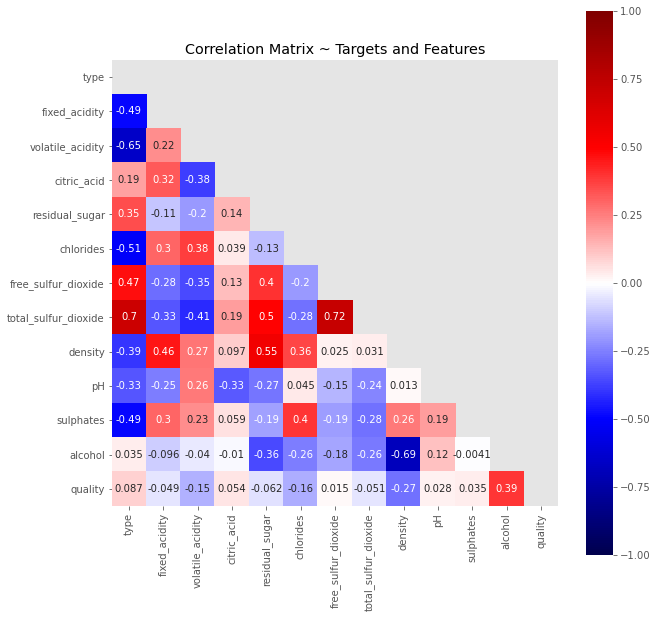

In [10]:
# Check if there are any high correlation between features
plt.figure(figsize=(10 , 10))

matrix = np.triu(df.corr())
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, square = True, mask = matrix );
plt.title("Correlation Matrix ~ Targets and Features")

/Users/danielchang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


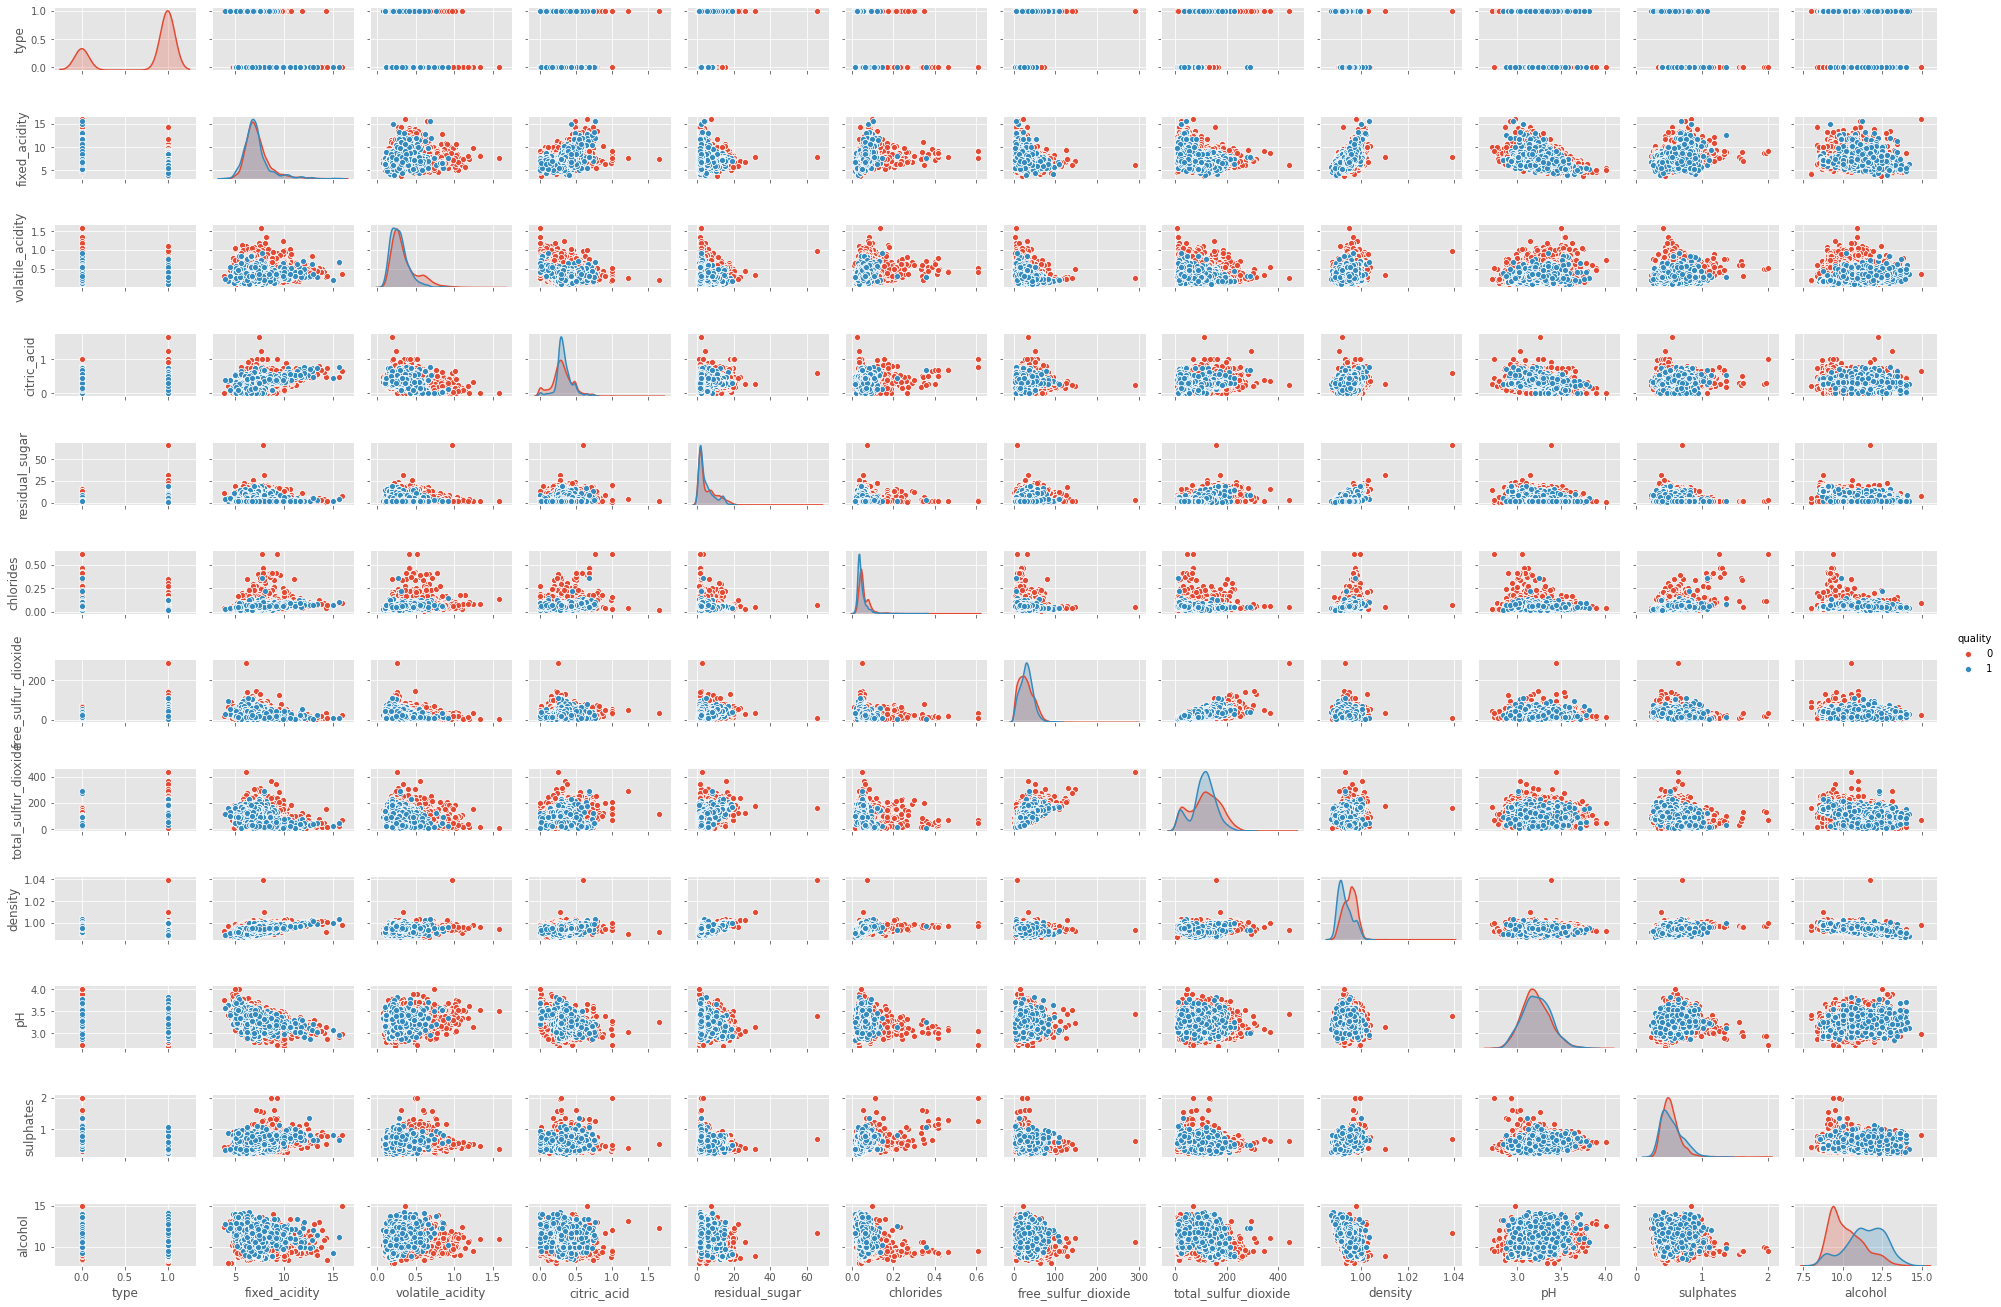

In [11]:
sns.pairplot(df, height=1.5, aspect=1.5, hue='quality');

## NOW WE START MODELLING!!

In [12]:
topgrade = (df['quality'] == 1).sum()
bottomgrade = (df['quality'] != 1).sum()

In [13]:
print(f'Class 0: {bottomgrade}')
print(f'Class 1: {topgrade}')
print(f'Proportion: {round(bottomgrade / topgrade, 2)}%')
print(f'Percentage of Majority Class: {round(bottomgrade / (df.quality.count()), 4)*100}%')
print(f'Percentage of Minority Class: {round(topgrade / (df.quality.count()), 4)*100}%')

Class 0: 5192
Class 1: 1271
Proportion: 4.08%
Percentage of Majority Class: 80.33%
Percentage of Minority Class: 19.67%


<ipython-input-14-718184a45419>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


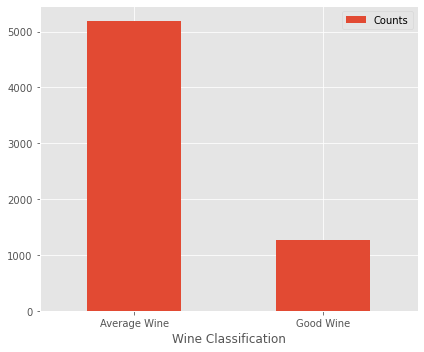

In [14]:
dic_class = {'Average Wine': 5192, 'Good Wine' : 1271}


df_class = pd.DataFrame([dic_class], index=['Counts']).transpose()

fig, ax= plt.subplots(1,1, figsize=(6,5))

df_class.plot.bar(ax=ax)
plt.xticks(rotation=0)
ax.set_xlabel('Wine Classification')
fig.tight_layout()
fig.show()

In [15]:
# We use simple validation to create our train/validation/test split
# This will become particularly important as we calculate our error metrics

X, y = df.drop('quality',axis=1), df['quality']

# hold out 20% of the data for final testing
X_train_val , X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=10)
# hold out another 20% of the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [16]:
#Oversampling with Synthetic Minority Oversampling Technique(SMOTE), since we want to oversample minority class
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)
X_smoted_scaled, y_smoted_scaled = SMOTE(random_state=42).fit_sample(X_train_scaled,y_train)

In [17]:
Counter(y_smoted)

Counter({0: 3116, 1: 3116})

In [18]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)
X_under_scaled, y_under_scaled = RandomUnderSampler(random_state=42).fit_sample(X_train_scaled,y_train)

In [19]:
Counter(y_under)

Counter({0: 761, 1: 761})

In [20]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)
X_adasyn_scaled, y_adasyn_scaled = ADASYN(random_state=42).fit_sample(X_train_scaled,y_train)

In [21]:
Counter(y_adasyn)

Counter({0: 3116, 1: 3192})

In [22]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_scaled, y_train.values, method='lasso')

Computing regularization path using the LARS ...


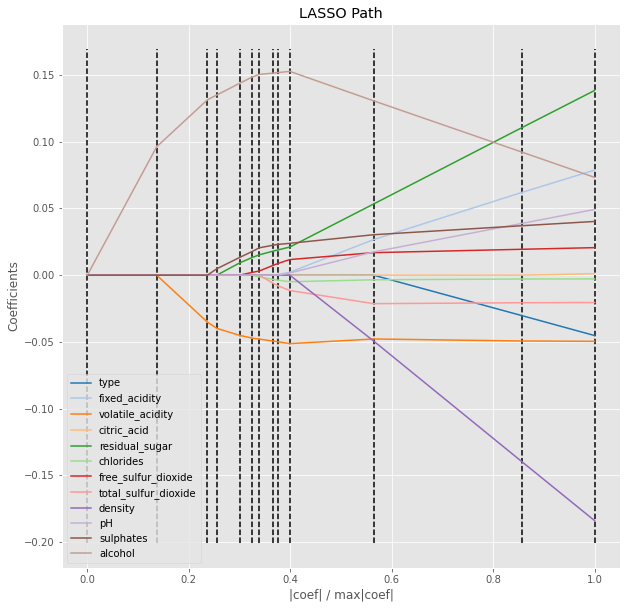

In [23]:
# plotting the LARS path
from cycler import cycler
from matplotlib.cm import get_cmap

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]


plt.rc('axes', prop_cycle =(cycler(color =['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
                                            '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
                                            '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
                                            '#17becf', '#9edae5'])))

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [24]:
def CVModeling (estimator, parameters, features, target):
    scoring = {'AUC': make_scorer (roc_auc_score), 'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score), 'F1': make_scorer(f1_score)}

    grid_search = GridSearchCV(estimator, parameters, cv= 5, scoring=scoring, refit='recall' , n_jobs=4, return_train_score=True)
    grid_search.fit(features, target)

    print ('Best parameters: {}'.format(grid_search.best_params_))
    print (f'Best score: {grid_search.best_score_:.3f}')
    
    
    AUC_test = np.mean(grid_search.cv_results_['mean_test_AUC'])
    AUC_test_std = np.mean(grid_search.cv_results_['std_test_AUC'])
    
    precision_test = np.mean(grid_search.cv_results_['mean_test_precision'])
    precision_test_std = np.mean(grid_search.cv_results_['std_test_precision'])
    
    recall_test = np.mean(grid_search.cv_results_['mean_test_recall'])
    recall_test_std = np.mean(grid_search.cv_results_['std_test_recall'])
    
    F1_test = np.mean(grid_search.cv_results_['mean_test_F1'])
    F1_test_std = np.mean(grid_search.cv_results_['std_test_F1'])
    
        
    print(f'Mean AUC test score: {AUC_test:.3f} +- {AUC_test_std:.3f}')
    print(f'Mean precision test score: {precision_test:.3f} +- {precision_test_std:.3f}')
    print(f'Mean recall test score: {recall_test:.3f} +- {recall_test_std:.3f}')
    print(f'Mean F1 test score: {F1_test:.3f} +- {F1_test_std:.3f}')
    
    return 

In [25]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors' : [1,2,3,4,5,6,7,8]}
CVModeling (knn, parameters, X_train, y_train)

Best parameters: {'n_neighbors': 1}
Best score: 0.491
Mean AUC test score: 0.592 +- 0.014
Mean precision test score: 0.472 +- 0.048
Mean recall test score: 0.255 +- 0.026
Mean F1 test score: 0.317 +- 0.030


In [26]:
logit = LogisticRegression()
parameters ={'C' : [100, 200, 300, 400, 500, 600, 700 , 800, 900,1000]}
CVModeling(logit, parameters, X_train, y_train)

Best parameters: {'C': 400}
Best score: 0.221
Mean AUC test score: 0.586 +- 0.012
Mean precision test score: 0.557 +- 0.078
Mean recall test score: 0.215 +- 0.017
Mean F1 test score: 0.309 +- 0.026


/Users/danielchang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
decisiontree = DecisionTreeClassifier()
parameters = {'max_depth' : [2,3,4,5,6,7,8]}
CVModeling (decisiontree, parameters, X_train, y_train)

Best parameters: {'max_depth': 8}
Best score: 0.449
Mean AUC test score: 0.623 +- 0.026
Mean precision test score: 0.486 +- 0.069
Mean recall test score: 0.315 +- 0.069
Mean F1 test score: 0.372 +- 0.061


In [28]:
nb = BernoulliNB()
parameters = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
CVModeling (nb, parameters, X_train, y_train)

Best parameters: {'alpha': 0.01}
Best score: 0.000
Mean AUC test score: 0.500 +- 0.000
Mean precision test score: 0.000 +- 0.000
Mean recall test score: 0.000 +- 0.000
Mean F1 test score: 0.000 +- 0.000


In [29]:
RC = RandomForestClassifier()
parameters = { 'n_estimators': [100, 200, 300, 400,500],'max_depth': [3, 4, 5, 6, 7, 8,9,10], 'bootstrap': [True,False]}
CVModeling (RC, parameters, X_train, y_train)

Best parameters: {'bootstrap': False, 'max_depth': 10, 'n_estimators': 200}
Best score: 0.489
Mean AUC test score: 0.621 +- 0.013
Mean precision test score: 0.708 +- 0.070
Mean recall test score: 0.269 +- 0.029
Mean F1 test score: 0.369 +- 0.032


/Users/danielchang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


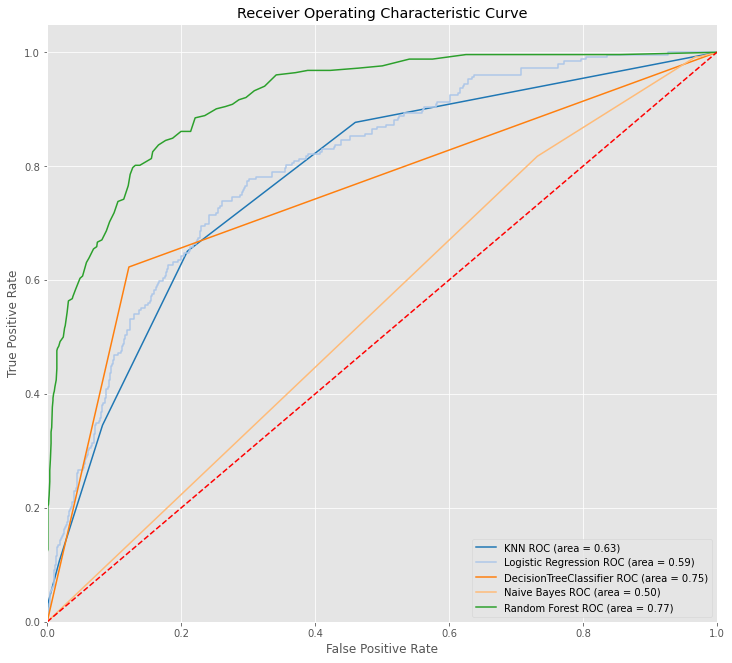

In [30]:
plt.figure(figsize=(12,11))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'KNN',
    'model': KNeighborsClassifier(),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'DecisionTreeClassifier',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'Naive Bayes',
    'model': BernoulliNB(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()   # Display

# MODEL OF CHOICE!

Precision: 83.8462%,   Recall: 43.2540%

F1 score = 57.0681% 

ROC AUC score = 70.6183% 


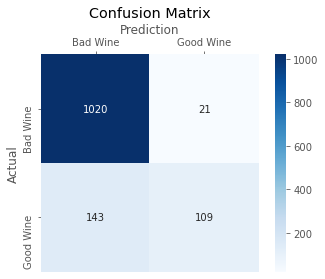

In [31]:
#DT = DecisionTreeClassifier(max_depth = 8)
RC = RandomForestClassifier(n_estimators = 200 , max_depth = 10 , bootstrap =False)
RC.fit(X_train,y_train)

#y_predict = RC.predict(X_test)
y_predict = (RC.predict_proba(X_test)[:, 1] >= 0.56)

#print("\nDefault threshold: 0.5")
print("Precision: {:6.4f}%,   Recall: {:6.4f}%".format(100*precision_score(y_test, y_predict), 
                                                     100*recall_score(y_test, y_predict)))

print("\nF1 score = {:6.4f}% ".format(100*f1_score(y_test, y_predict)))
print("\nROC AUC score = {:6.4f}% ".format(100*roc_auc_score(y_test, y_predict)))

# Print confusion matrix for kNN
f, ax = plt.subplots(figsize=(6, 4))
confusionmatrix = confusion_matrix(y_test, y_predict)
sns.heatmap(confusionmatrix, cmap=plt.cm.Blues, annot=True, square=True,fmt ='g',xticklabels=['Bad Wine', 'Good Wine'], yticklabels=['Bad Wine', 'Good Wine'])

ax.set_title('Confusion Matrix')
ax.set_ylabel('Actual')
ax.set_xlabel('Prediction')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

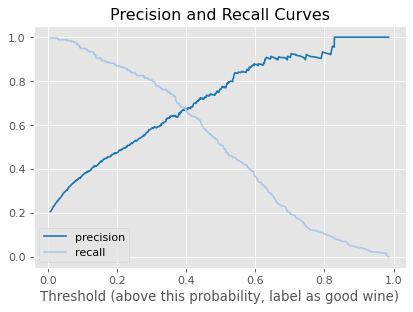

In [32]:
## We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, RC.predict_proba(X_test)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as good wine)');
plt.title('Precision and Recall Curves');

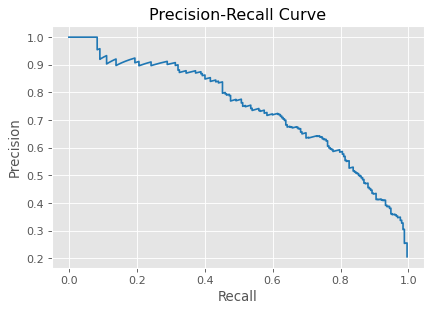

In [33]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [34]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, RC.predict_proba(X_test)[:,1])

ROC AUC score =  0.9089626885015933


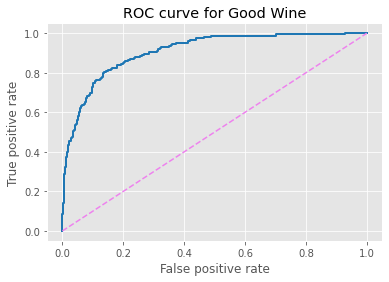

In [35]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Good Wine');
print("ROC AUC score = ", roc_auc_score(y_test, RC.predict_proba(X_test)[:,1]))

In [36]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, RC.predict_proba(X_test)[:,1] )))

Log-loss on logit: 0.2951


In [37]:
np.set_printoptions(suppress=True)
RC.feature_importances_

array([0.00299431, 0.06427374, 0.0854518 , 0.07280204, 0.08603177,
       0.07834603, 0.06238879, 0.07247144, 0.13922402, 0.06718361,
       0.07005205, 0.1987804 ])

In [38]:
X.columns

Index(['type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [39]:
df_feature_importance = pd.DataFrame(list(zip(X.columns, RC.feature_importances_)))

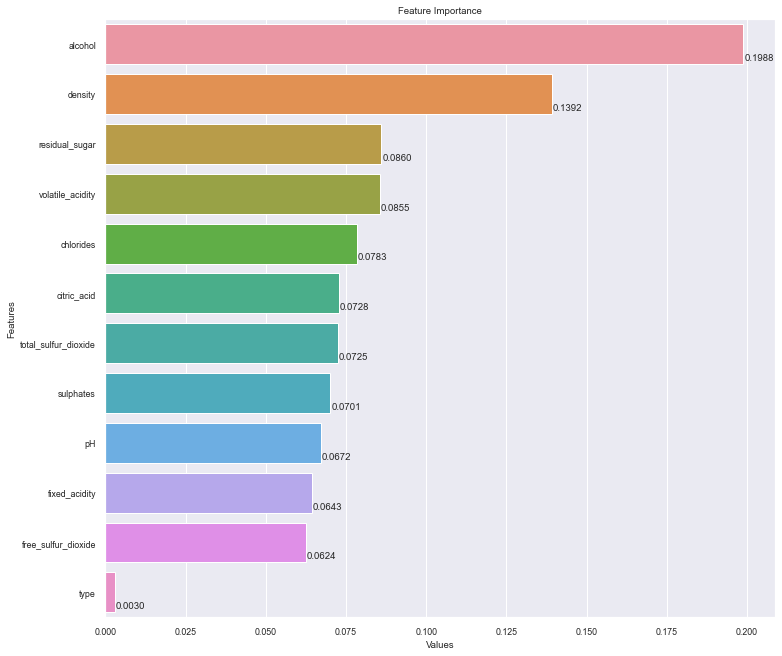

In [40]:
df_feature_importance.rename(columns={0:'Features', 1:'Values'}, inplace=True)
df_feature_importance = df_feature_importance.sort_values(by = 'Values', ascending = False)

plt.figure(figsize=(12,11))
sns.set_style('whitegrid')
sns.set(font_scale=0.8)

ax = sns.barplot(x = 'Values',y='Features', data = df_feature_importance)
ax.set_title("Feature Importance")

for p in ax.patches:
    ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.8), xytext=(1, 4), textcoords='offset pixels')
plt.show()

In [41]:
df_predicted = pd.DataFrame(y_predict)
df_predicted.rename(columns={0:'Good_Wine'}, inplace=True)
df_predicted.head(5)

,Good_Wine
0,True
1,False
2,False
3,False
4,False


In [42]:
X_test1 = X_test
X_test1 = X_test1.reset_index()

In [43]:
X_test1 = X_test1.drop(['index'], axis = 1)

In [44]:
X_test1.type.replace(0,'red', inplace = True)
X_test1.type.replace(1, 'white', inplace = True)

In [45]:
X_test1.head(5)

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,white,5.3,0.36,0.27,6.3,0.028,40.0,132.0,0.99186,3.37,0.40,11.6
1,white,6.2,0.28,0.33,1.7,0.029,24.0,111.0,0.99000,3.24,0.50,12.1
2,white,7.8,0.28,0.31,2.1,0.046,28.0,208.0,0.99434,3.23,0.64,9.8
3,white,6.4,0.35,0.21,2.1,0.051,46.0,171.0,0.99320,3.16,0.50,9.5
4,white,8.3,0.30,0.36,10.0,0.042,33.0,169.0,0.99820,3.23,0.51,9.3


In [46]:
result = pd.concat([df_predicted, X_test1], axis=1)
result.head()

,Good_Wine,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,True,white,5.3,0.36,0.27,6.3,0.028,40.0,132.0,0.99186,3.37,0.40,11.6
1,False,white,6.2,0.28,0.33,1.7,0.029,24.0,111.0,0.99000,3.24,0.50,12.1
2,False,white,7.8,0.28,0.31,2.1,0.046,28.0,208.0,0.99434,3.23,0.64,9.8
3,False,white,6.4,0.35,0.21,2.1,0.051,46.0,171.0,0.99320,3.16,0.50,9.5
4,False,white,8.3,0.30,0.36,10.0,0.042,33.0,169.0,0.99820,3.23,0.51,9.3


In [47]:
result.sort_values(by = 'Good_Wine', ascending = False).head(10)

,Good_Wine,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,True,white,5.3,0.36,0.27,6.30,0.028,40.0,132.0,0.99186,3.37,0.40,11.6
534,True,white,7.3,0.25,0.36,2.10,0.034,30.0,177.0,0.99085,3.25,0.40,11.9
1130,True,white,6.5,0.40,0.31,3.50,0.046,22.0,147.0,0.99024,3.15,0.31,12.0
1129,True,red,7.2,0.37,0.32,2.00,0.062,15.0,28.0,0.99470,3.23,0.73,11.3
181,True,white,7.9,0.44,0.37,5.85,0.033,27.0,93.0,0.99200,3.16,0.54,12.6
182,True,white,6.6,0.21,0.29,5.35,0.029,43.0,106.0,0.99112,2.93,0.43,11.5
1119,True,white,7.4,0.19,0.30,12.80,0.053,48.5,229.0,0.99860,3.14,0.49,9.1
193,True,white,6.0,0.28,0.27,15.50,0.036,31.0,134.0,0.99408,3.19,0.44,13.0
833,True,white,6.9,0.25,0.26,5.20,0.024,36.0,135.0,0.99480,3.16,0.72,10.7
196,True,white,7.7,0.38,0.40,2.00,0.038,28.0,152.0,0.99060,3.18,0.32,12.9


In [48]:
result.to_csv('Result.csv')